# **STEP 1: BRIEF DESCRIPTION OF THE PROBLEM AND DATA**
A Generative Adversarial Network (GAN) is a class of deep learning models used to generate new data samples that resemble a given dataset. In this challenge, we will train a specific type of GAN called a CycleGAN to generate images from photographs that capture the style of classic Monet paintings.

The dataset is downloaded from the Kaggle competition [I'm Something of a Painter Myself](https:/https://www.kaggle.com/competitions/gan-getting-started/), and consists of the following:
<br><br>
**Monet Paintings:** 300 Monet-style images, each with a size of 256x256 pixels and three color channels (RGB). These images represent the target style that the GAN model aims to replicate.

**Photos:** 7028 real-world images, also of size 256x256 pixels with RGB channels. These images serve as the input for the GAN, which transforms them into Monet-style paintings.
<br><br>
The data is unpaired, meaning that each photo does not have a corresponding Monet painting. A CycleGAN is ideal for this scenario, as it can learn to map one domain (i.e., photos) to another (i.e., Monet-style paintings) without paired data. Through an iterative process, the model generates new images and evaluates their authenticity using a discriminator component. Over time, the model learns to create images that closely resemble Monet paintings.

The effectiveness of this process will be measured by having the model generate a zipped folder containing 7,000 to 10,000 Monet-style images. These images will then be submitted to the Kaggle competition for evaluation.


In [ ]:
# Import necessary libraries
import os
import zipfile
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from skimage.exposure import match_histograms
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications.inception_v3 import InceptionV3
from scipy.linalg import sqrtm

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# **STEP 2: EXPLORATORY DATA ANALYSIS (EDA)**
To understand the dataset better, we downloaded and unzipped the files to prepare for any necessary preprocessing. Visualizations provide insight into the complexity of the images we’ll be working with. Both .jpg and .trec files are included, but we use the .jpg format for this project.
<br><br>
*Key Steps in Initial Exploration:*

**Visual Inspection:** We begin by visualizing the first few Monet and photo images to gain an understanding of their styles. Monet images exhibit distinctive artistic features such as brushstrokes, color palettes, and textures, while the photo images capture realistic scenes.

**Color Distribution Analysis:** Quantifying color differences between the two datasets, we calculated and plotted RGB histograms for each. Monet images tend to show a greater concentration in mid-range color intensities, whereas the photos display a gradual taper from high frequency at low intensities to lower frequency at high intensities.

**Statistical Summary:** We calculated the mean and variance for each color channel (R, G, and B) across both datasets. The photo dataset generally has lower mean color values and greater variance than the Monet dataset. This aligns with expectations, as paintings often use a limited color palette compared to natural photos.

**Histogram Matching Visualization:** To further explore potential preprocessing techniques, we visualized histogram matching to adjust the color distributions of photos to resemble Monet images. While we chose not to apply this transformation for model training, it could be worth revisiting in future models.

**Image Preprocessing and Augmentation:** We resized both datasets to 256x256 pixels and normalized pixel values to the range [-1, 1] to meet the input requirements of the CycleGAN model. Additionally, we applied augmentation—random horizontal flips, rotations, zooms, and translations—to the Monet dataset to increase variability and improve model generalization. Augmentation wasn’t applied to the photo images to maintain their original appearance but could be explored in future iterations.
<br><br>
*Plan of Analysis:*

Based on our EDA, we aim to:

1. Train a CycleGAN model using augmented Monet images to improve performance and stability.

2. Evaluate the model’s generated Monet-style images from photos by monitoring the Fréchet Inception Distance (FID) score, which will help us quantify perceptual similarity to genuine Monet paintings. We will also conduct visual inspections of progress as the model trains.


In [ ]:
!gdown --id 1hu13cOQY3rEqzBF8R6U9wXgH4W-9QaYQ -O gan-getting-started.zip

# Unzip the downloaded file
with zipfile.ZipFile('gan-getting-started.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/gan-getting-started')

# Verify the contents
!ls /content/gan-getting-started

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1hu13cOQY3rEqzBF8R6U9wXgH4W-9QaYQ
From (redirected): https://drive.google.com/uc?id=1hu13cOQY3rEqzBF8R6U9wXgH4W-9QaYQ&confirm=t&uuid=ea477488-7c5c-409a-a167-f6a7fd4ddd42
To: /content/gan-getting-started.zip
100% 385M/385M [00:06<00:00, 56.5MB/s]
monet_jpg  monet_tfrec	photo_jpg  photo_tfrec


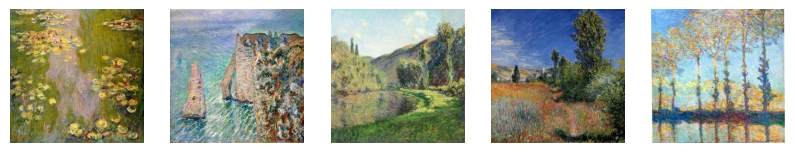

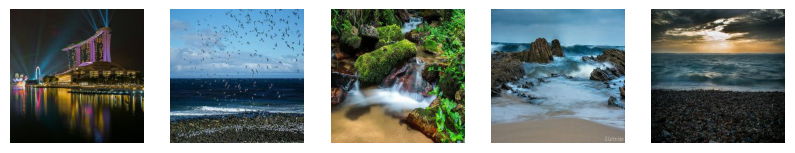

In [ ]:
# Define paths to Monet and photo folders
monet_path = '/content/gan-getting-started/monet_jpg'
photo_path = '/content/gan-getting-started/photo_jpg'

# Visualize the first 5 Monet and Photo images
def visualize_images(folder_path, num_images=5):
    image_files = os.listdir(folder_path)[:num_images]
    plt.figure(figsize=(10, 5))
    for i, img_file in enumerate(image_files):
        img = mpimg.imread(os.path.join(folder_path, img_file))
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

visualize_images(monet_path, 5)
visualize_images(photo_path, 5)

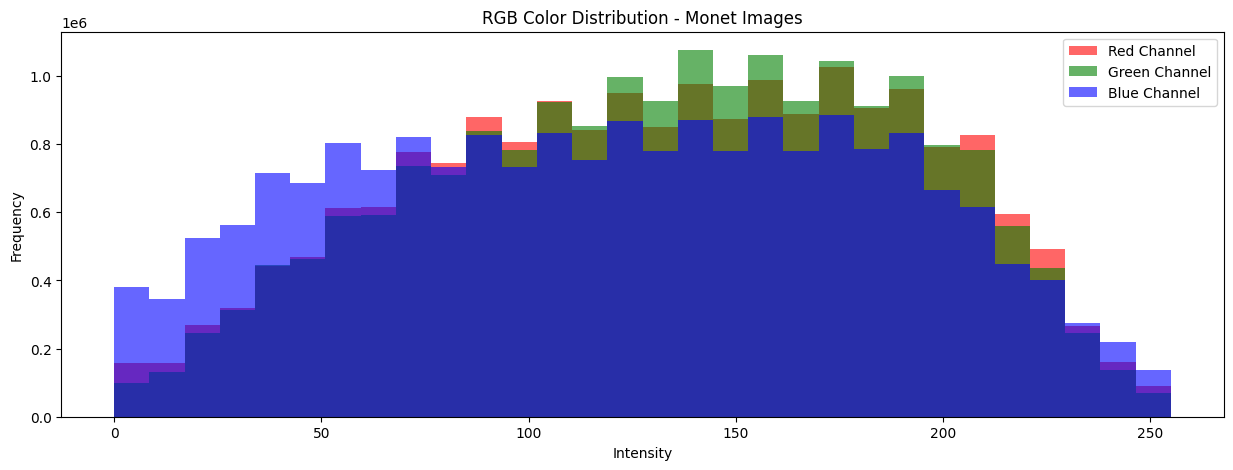

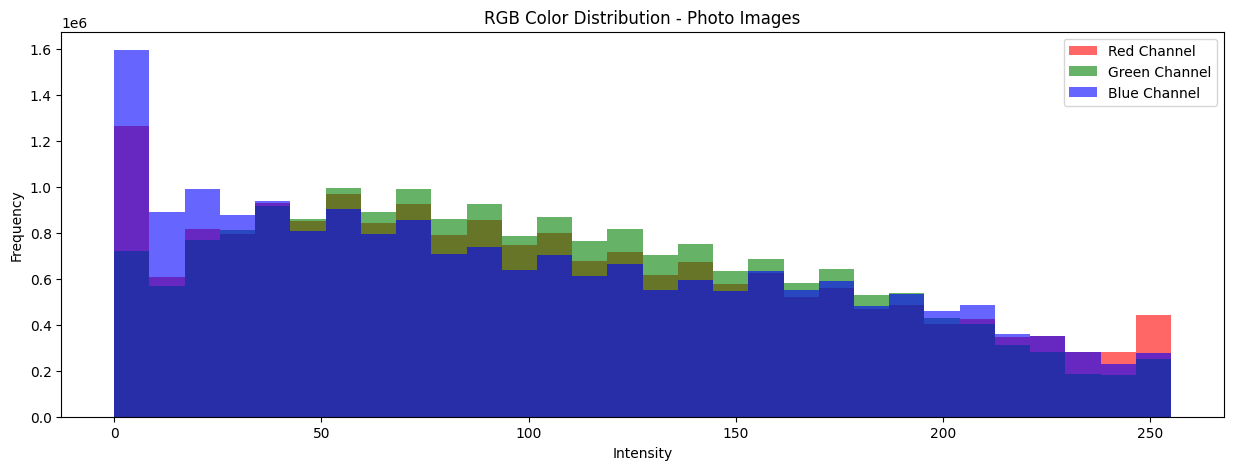

In [ ]:
# Load images into memory
def load_images(folder, limit=None):
    images = []
    for filename in os.listdir(folder)[:limit]:
        img = mpimg.imread(os.path.join(folder, filename))
        images.append(img)
    return images

# Load Monet and photo images
monet_images = load_images(monet_path, limit=300)  # Load first 300 Monet images
photo_images = load_images(photo_path, limit=300)  # Load first 300 photo images

# Plot RGB color histograms for Monet and photo images
def plot_color_histogram(images, title):
    r_values, g_values, b_values = [], [], []
    for img in images:
        r_values.append(img[:, :, 0].flatten())
        g_values.append(img[:, :, 1].flatten())
        b_values.append(img[:, :, 2].flatten())

    # Flatten lists and plot histograms
    r_values = np.concatenate(r_values)
    g_values = np.concatenate(g_values)
    b_values = np.concatenate(b_values)

    plt.figure(figsize=(15, 5))
    plt.hist(r_values, bins=30, color='red', alpha=0.6, label='Red Channel')
    plt.hist(g_values, bins=30, color='green', alpha=0.6, label='Green Channel')
    plt.hist(b_values, bins=30, color='blue', alpha=0.6, label='Blue Channel')
    plt.title(f"RGB Color Distribution - {title}")
    plt.xlabel("Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Plot color histograms for Monet images and photos
plot_color_histogram(monet_images, "Monet Images")
plot_color_histogram(photo_images, "Photo Images")

In [ ]:
# Create function to calculate mean and variance of each color
def calculate_mean_variance(images, title):
    r_mean, g_mean, b_mean = [], [], []
    r_var, g_var, b_var = [], [], []
    for img in images:
        r_mean.append(np.mean(img[:, :, 0]))
        g_mean.append(np.mean(img[:, :, 1]))
        b_mean.append(np.mean(img[:, :, 2]))
        r_var.append(np.var(img[:, :, 0]))
        g_var.append(np.var(img[:, :, 1]))
        b_var.append(np.var(img[:, :, 2]))

    print(f"{title} - Mean (R, G, B): {np.mean(r_mean):.2f}, {np.mean(g_mean):.2f}, {np.mean(b_mean):.2f}")
    print(f"{title} - Variance (R, G, B): {np.mean(r_var):.2f}, {np.mean(g_var):.2f}, {np.mean(b_var):.2f}")

# Calculate mean and variance for Monet images and photos
calculate_mean_variance(monet_images, "Monet Images")
calculate_mean_variance(photo_images, "Photo Images")

Monet Images - Mean (R, G, B): 132.96, 133.73, 121.57
Monet Images - Variance (R, G, B): 2523.90, 2317.38, 2667.41
Photo Images - Mean (R, G, B): 104.39, 105.43, 100.19
Photo Images - Variance (R, G, B): 3477.35, 2879.73, 3550.95


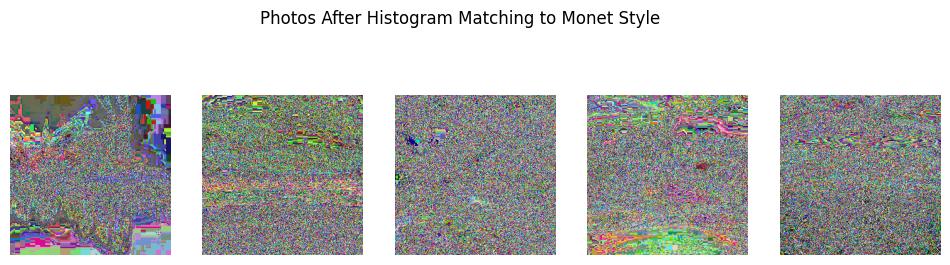

In [ ]:
# Define histogram matching function
def histogram_matching(source_images, reference_images):
    matched_images = []
    for src_img in source_images:
        # Use a random reference image from Monet dataset
        ref_img = reference_images[np.random.randint(0, len(reference_images))]
        # Apply histogram matching
        matched = match_histograms(src_img, ref_img)
        matched_images.append(matched)
    return np.array(matched_images)

# Apply histogram matching to photos using Monet images as reference
matched_photos = histogram_matching(photo_images, monet_images)

# Display matched images for comparison
plt.figure(figsize=(12, 6))
for i, img in enumerate(matched_photos[:5]):
    plt.subplot(2, 5, i + 1)
    plt.imshow((img * 127.5 + 127.5).astype(np.uint8))  # Rescale back to [0, 255] for display
    plt.axis('off')
plt.suptitle("Photos After Histogram Matching to Monet Style")
plt.show()

In [ ]:
# Resize and Normalize Images
def preprocess_image(image):
    # Resize to 256x256 and normalize to [-1, 1] range
    image = tf.image.resize(image, [256, 256])
    image = (image / 127.5) - 1
    return image

# Load and Preprocess Images from Folders
def load_images_from_folder_tf(folder, limit=None):
    filenames = os.listdir(folder)[:limit]
    image_paths = [os.path.join(folder, filename) for filename in filenames]
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)

    def _process_image(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = preprocess_image(img)
        return img

    dataset = dataset.map(_process_image)
    return dataset

# Load and preprocess images for Monet and photos
monet_images_tf = load_images_from_folder_tf(monet_path, limit=300)
photo_images_tf = load_images_from_folder_tf(photo_path, limit=5000)


# Data Augmentation for Monet Images
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1)
])

# Apply augmentation only to the Monet images
augmented_monet_images = monet_images_tf.map(lambda x: data_augmentation(x))

# Create tf.data Datasets for Efficient Loading
BATCH_SIZE = 16
monet_dataset = augmented_monet_images.batch(BATCH_SIZE).shuffle(buffer_size=1000)
photo_dataset = photo_images_tf.batch(BATCH_SIZE).shuffle(buffer_size=1000)

# Verify by checking the first few elements in the monet dataset
for img_batch in monet_dataset.take(1):
    print(img_batch.shape)

(16, 256, 256, 3)


# **STEP 3: MODEL ARCHITECTURE**
The CycleGAN model was chosen for this project as a way to capture the unique characteristics found in nonpair images from both datasets, and transform the photos provided into monet-style images. We have chosen the architecture used in order to balance both complexity and computational efficiency, since working with images uses a significant amount of memory and processing time. Below is a breakdown of some of the choices implemented and the rationale behind them:
<br><br>
***Generator Architecture***

There are two generator networks being used in this model (one for generating Monet-style images from photos and the other for the reverse transformation). Each generator is formed of convolutional layers followed by transpose convolutional layers, allowing the model to learn transformations at different resolutions, with the hope of capturing both fine details and broader structural patterns. Our architecture includes four convolutional layers to down-sample and four transpose convolutional layers to up-sample back to the original resolution:
<br><br>
**Downsampling Layers:** There are four convolutional layers with increasing filter sizes (64, 128, 256, and 512) to progressively downsample the input image. This downsampling helps reduce the spatial dimensions while extracting higher-level features.

**Upsampling Layers:**Transpose convolutional layers then upsample in order to reconstruct the image back to its original size (256x256) while applying learned transformations. This reversal of the down-sampling, aims to produce an output that resembles the Monet painting style.

**Activation Layer:** A final activation layer with a tanh function normalizes the output to ensure that the generated image is in the same range as the input data, which is scaled to [-1, 1].
<br><br>
***Discriminator Architecture***

The primary role of the discriminators is to determine whether an image is real or has been generated by the model. Using convolutional layers with LeakyReLU activations the discriminators output a patch of probabilities, allowing them to focus on smaller sections of the image rather than the whole thing. The following architecture was included:
<br><br>
**Convolutional Layers:** Each convolutional layer in the discriminator downsamples the image using a larger filter size (64, 128, 256, and 512) to progressively capture features at different levels.

**LeakyReLU Activations:** In order to ensure stable training, the LeakyReLU activation function is used throughout to avoid vanishing gradients.

**Final Layer:** The final output layer provides a single-channel output, representing the probability that each patch in the image is real (i.e., closely resembling the Monet style).
<br><br>
These architecture decisions are made to balance complexity and efficiency, handle both fine and large-scale features, and seek stability in our training process.


In [ ]:
# Build the Generator Model
def build_generator():
    inputs = layers.Input(shape=[256, 256, 3])

    # Encoder
    e1 = layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    e2 = layers.Conv2D(128, 4, strides=2, padding='same')(e1)
    e3 = layers.Conv2D(256, 4, strides=2, padding='same')(e2)
    e4 = layers.Conv2D(512, 4, strides=2, padding='same')(e3)

    # Decoder
    d1 = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(e4)
    d2 = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(d1)
    d3 = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(d2)
    d4 = layers.Conv2DTranspose(3, 4, strides=2, padding='same')(d3)

    # Output layer
    outputs = layers.Activation('tanh')(d4)

    return Model(inputs, outputs)

In [ ]:
# Build the Discriminator Model
def build_discriminator():
    inputs = layers.Input(shape=[256, 256, 3])

    x = layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(512, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(1, 4, strides=1, padding='same')(x)

    return Model(inputs, x)

In [ ]:

# Build CycleGAN model by combining the generators and discriminators
class CycleGAN(Model):
    def __init__(self, generator_g, generator_f, discriminator_x, discriminator_y):
        super(CycleGAN, self).__init__()
        self.generator_g = generator_g  # Generator G: Photo to Monet
        self.generator_f = generator_f  # Generator F: Monet to Photo
        self.discriminator_x = discriminator_x  # Discriminator for Photos
        self.discriminator_y = discriminator_y  # Discriminator for Monet images

    def call(self, inputs):
        return self.generator_g(inputs)

In [ ]:
# Instantiate models
generator_g = build_generator()
generator_f = build_generator()
discriminator_x = build_discriminator()
discriminator_y = build_discriminator()


generator_g.summary()
generator_f.summary()
discriminator_x.summary()
discriminator_y.summary()

# Create the CycleGAN model, which will be used for training
cyclegan = CycleGAN(generator_g, generator_f, discriminator_x, discriminator_y)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 512)         │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 256)         │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 128, 128, 64)        │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 256, 256, 3)         │           3,075 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256, 256, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,512,579 (21.03 MB)

 Trainable params: 5,512,579 (21.03 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 512)         │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 32, 32, 256)         │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 64, 64, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 128, 128, 64)        │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 256, 256, 3)         │           3,075 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 256, 256, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,512,579 (21.03 MB)

 Trainable params: 5,512,579 (21.03 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 128, 128, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 512)         │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 16, 16, 1)           │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,764,737 (10.55 MB)

 Trainable params: 2,764,737 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 128, 128, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 64, 64, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 16, 16, 512)         │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 16, 16, 1)           │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,764,737 (10.55 MB)

 Trainable params: 2,764,737 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Optimizers and loss functions
generator_g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

def discriminator_loss(real, fake):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real), real)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake), fake)
    return real_loss + fake_loss

def generator_loss(real_x, real_y, fake_x, fake_y, cycled_x, cycled_y, same_x, same_y):
    # Adversarial loss: encourage generated images to look like real images
    adv_loss_g = tf.reduce_mean(tf.square(fake_y - 1))
    adv_loss_f = tf.reduce_mean(tf.square(fake_x - 1))

    # Cycle consistency loss: enforce that G(F(y)) ≈ y and F(G(x)) ≈ x
    cycle_loss_x = tf.reduce_mean(tf.abs(real_x - cycled_x))
    cycle_loss_y = tf.reduce_mean(tf.abs(real_y - cycled_y))

    # Identity loss: F(x) ≈ x and G(y) ≈ y
    identity_loss_x = tf.reduce_mean(tf.abs(real_x - same_x))
    identity_loss_y = tf.reduce_mean(tf.abs(real_y - same_y))

    # Total generator loss
    total_g_loss = adv_loss_g + cycle_loss_y + identity_loss_y
    total_f_loss = adv_loss_f + cycle_loss_x + identity_loss_x

    # Return combined loss for both generators
    return total_g_loss + total_f_loss

In [ ]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape_g, tf.GradientTape(persistent=True) as tape_d:
        # Generate fake images
        fake_y = cyclegan.generator_g(real_x, training=True)
        fake_x = cyclegan.generator_f(real_y, training=True)

        # Cycle Consistency
        cycled_x = cyclegan.generator_f(fake_y, training=True)
        cycled_y = cyclegan.generator_g(fake_x, training=True)

        # Identity Mapping
        same_x = cyclegan.generator_f(real_x, training=True)
        same_y = cyclegan.generator_g(real_y, training=True)

        # Calculate generator losses
        g_loss = generator_loss(real_x, real_y, fake_x, fake_y, cycled_x, cycled_y, same_x, same_y)

        # Discriminator Loss
        real_d_x = cyclegan.discriminator_x(real_x, training=True)
        fake_d_x = cyclegan.discriminator_x(fake_x, training=True)
        d_x_loss = discriminator_loss(real_d_x, fake_d_x)

        real_d_y = cyclegan.discriminator_y(real_y, training=True)
        fake_d_y = cyclegan.discriminator_y(fake_y, training=True)
        d_y_loss = discriminator_loss(real_d_y, fake_d_y)

    # Calculate and apply gradients
    gradients_of_generator_g = tape_g.gradient(g_loss, cyclegan.generator_g.trainable_variables)
    gradients_of_generator_f = tape_g.gradient(g_loss, cyclegan.generator_f.trainable_variables)
    gradients_of_discriminator_x = tape_d.gradient(d_x_loss, cyclegan.discriminator_x.trainable_variables)
    gradients_of_discriminator_y = tape_d.gradient(d_y_loss, cyclegan.discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(gradients_of_generator_g, cyclegan.generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(gradients_of_generator_f, cyclegan.generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(gradients_of_discriminator_x, cyclegan.discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(gradients_of_discriminator_y, cyclegan.discriminator_y.trainable_variables))

    return g_loss, d_x_loss, d_y_loss

Epoch 1/100 | Gen Loss: 3.2844 | Disc Loss (X): 0.5762 | Disc Loss (Y): 0.3752
Epoch 2/100 | Gen Loss: 2.8538 | Disc Loss (X): 0.4651 | Disc Loss (Y): 0.2983
Epoch 3/100 | Gen Loss: 2.7832 | Disc Loss (X): 0.4131 | Disc Loss (Y): 0.1111
Epoch 4/100 | Gen Loss: 2.3415 | Disc Loss (X): 0.1490 | Disc Loss (Y): 0.0724
Epoch 5/100 | Gen Loss: 2.5221 | Disc Loss (X): 0.0703 | Disc Loss (Y): 0.0250
Epoch 6/100 | Gen Loss: 2.3726 | Disc Loss (X): 0.0252 | Disc Loss (Y): 0.0117
Epoch 7/100 | Gen Loss: 2.5745 | Disc Loss (X): 0.0561 | Disc Loss (Y): 0.0094
Epoch 8/100 | Gen Loss: 2.1186 | Disc Loss (X): 0.1085 | Disc Loss (Y): 0.0948
Epoch 9/100 | Gen Loss: 2.0275 | Disc Loss (X): 0.0673 | Disc Loss (Y): 0.0347
Epoch 10/100 | Gen Loss: 2.0721 | Disc Loss (X): 0.0828 | Disc Loss (Y): 0.0818
Epoch 11/100 | Gen Loss: 1.9714 | Disc Loss (X): 0.0886 | Disc Loss (Y): 0.0334
Epoch 12/100 | Gen Loss: 2.1272 | Disc Loss (X): 0.0322 | Disc Loss (Y): 0.0211
Epoch 13/100 | Gen Loss: 2.3002 | Disc Loss (X): 

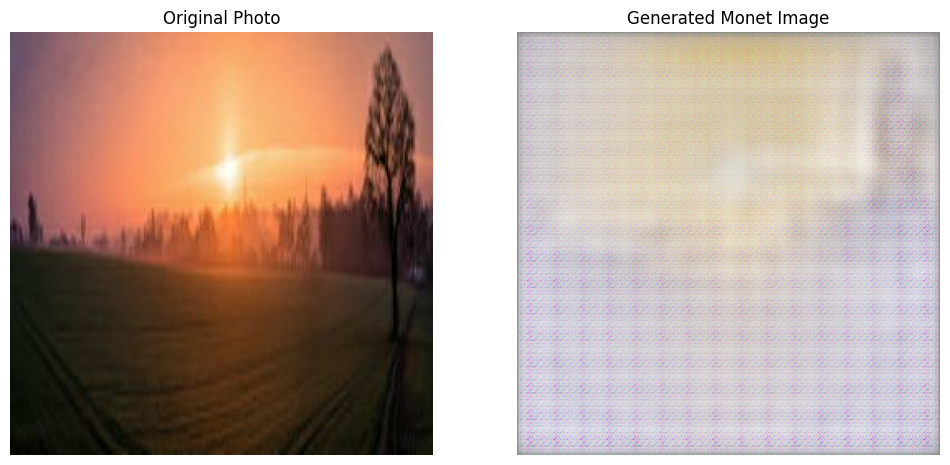

Epoch 26/100 | Gen Loss: 2.1708 | Disc Loss (X): 0.0018 | Disc Loss (Y): 0.0004
Epoch 27/100 | Gen Loss: 1.9132 | Disc Loss (X): 0.0025 | Disc Loss (Y): 0.0026
Epoch 28/100 | Gen Loss: 1.9892 | Disc Loss (X): 0.0019 | Disc Loss (Y): 0.3553
Epoch 29/100 | Gen Loss: 1.8194 | Disc Loss (X): 0.2843 | Disc Loss (Y): 0.0580
Epoch 30/100 | Gen Loss: 1.8360 | Disc Loss (X): 0.0652 | Disc Loss (Y): 0.0495
Epoch 31/100 | Gen Loss: 1.7657 | Disc Loss (X): 0.0206 | Disc Loss (Y): 0.0118
Epoch 32/100 | Gen Loss: 1.7720 | Disc Loss (X): 0.0212 | Disc Loss (Y): 0.0143
Epoch 33/100 | Gen Loss: 1.8347 | Disc Loss (X): 0.0202 | Disc Loss (Y): 0.0082
Epoch 34/100 | Gen Loss: 1.8505 | Disc Loss (X): 0.0072 | Disc Loss (Y): 0.0101
Epoch 35/100 | Gen Loss: 1.8186 | Disc Loss (X): 0.0062 | Disc Loss (Y): 0.0018
Epoch 36/100 | Gen Loss: 1.8765 | Disc Loss (X): 0.0017 | Disc Loss (Y): 0.0066
Epoch 37/100 | Gen Loss: 1.9543 | Disc Loss (X): 0.0044 | Disc Loss (Y): 0.3767
Epoch 38/100 | Gen Loss: 1.6818 | Disc L

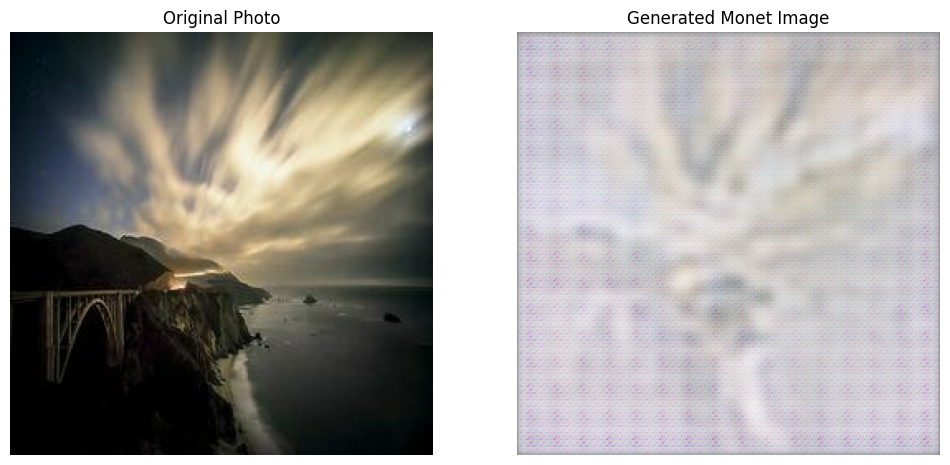

Epoch 51/100 | Gen Loss: 1.8396 | Disc Loss (X): 0.0049 | Disc Loss (Y): 0.0182
Epoch 52/100 | Gen Loss: 2.1757 | Disc Loss (X): 0.0097 | Disc Loss (Y): 0.0019
Epoch 53/100 | Gen Loss: 1.8152 | Disc Loss (X): 0.0014 | Disc Loss (Y): 0.0082
Epoch 54/100 | Gen Loss: 2.2435 | Disc Loss (X): 0.0136 | Disc Loss (Y): 0.0079
Epoch 55/100 | Gen Loss: 1.7066 | Disc Loss (X): 0.0020 | Disc Loss (Y): 0.0019
Epoch 56/100 | Gen Loss: 1.6877 | Disc Loss (X): 0.0019 | Disc Loss (Y): 0.0126
Epoch 57/100 | Gen Loss: 1.6866 | Disc Loss (X): 0.0015 | Disc Loss (Y): 0.0017
Epoch 58/100 | Gen Loss: 1.8583 | Disc Loss (X): 0.0008 | Disc Loss (Y): 0.0014
Epoch 59/100 | Gen Loss: 1.7571 | Disc Loss (X): 0.0021 | Disc Loss (Y): 0.0041
Epoch 60/100 | Gen Loss: 1.8292 | Disc Loss (X): 0.0010 | Disc Loss (Y): 0.0248
Epoch 61/100 | Gen Loss: 1.7407 | Disc Loss (X): 0.0038 | Disc Loss (Y): 0.0056
Epoch 62/100 | Gen Loss: 1.8762 | Disc Loss (X): 0.0006 | Disc Loss (Y): 0.0006
Epoch 63/100 | Gen Loss: 1.6864 | Disc L

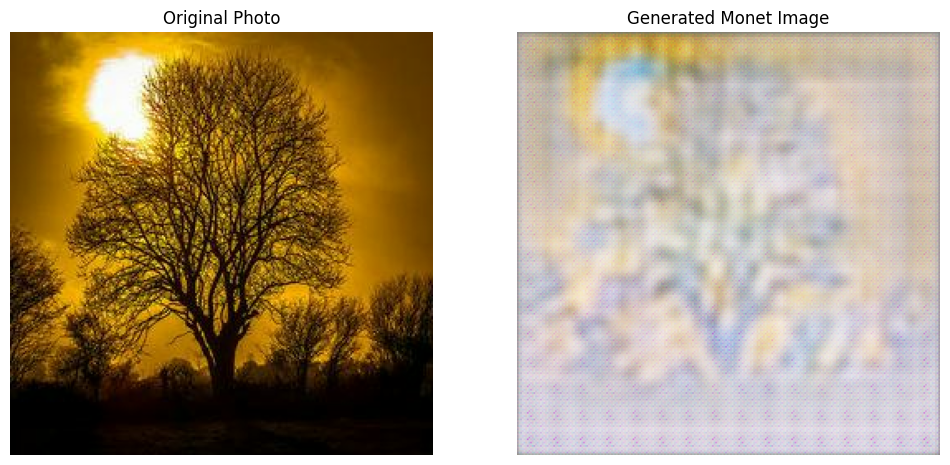

Epoch 76/100 | Gen Loss: 1.6878 | Disc Loss (X): 0.0116 | Disc Loss (Y): 0.0058
Epoch 77/100 | Gen Loss: 2.2126 | Disc Loss (X): 0.0050 | Disc Loss (Y): 0.0050
Epoch 78/100 | Gen Loss: 1.6643 | Disc Loss (X): 0.0031 | Disc Loss (Y): 0.0006
Epoch 79/100 | Gen Loss: 1.9418 | Disc Loss (X): 0.0023 | Disc Loss (Y): 0.0007
Epoch 80/100 | Gen Loss: 1.8146 | Disc Loss (X): 0.0017 | Disc Loss (Y): 0.0010
Epoch 81/100 | Gen Loss: 1.7329 | Disc Loss (X): 0.0026 | Disc Loss (Y): 0.0180
Epoch 82/100 | Gen Loss: 1.7406 | Disc Loss (X): 0.0013 | Disc Loss (Y): 0.0036
Epoch 83/100 | Gen Loss: 1.9480 | Disc Loss (X): 0.0007 | Disc Loss (Y): 0.0027
Epoch 84/100 | Gen Loss: 1.7001 | Disc Loss (X): 0.0065 | Disc Loss (Y): 0.0004
Epoch 85/100 | Gen Loss: 1.8266 | Disc Loss (X): 0.0055 | Disc Loss (Y): 0.0023
Epoch 86/100 | Gen Loss: 1.7519 | Disc Loss (X): 0.0011 | Disc Loss (Y): 0.0010
Epoch 87/100 | Gen Loss: 1.6524 | Disc Loss (X): 0.0004 | Disc Loss (Y): 0.0007
Epoch 88/100 | Gen Loss: 1.8382 | Disc L

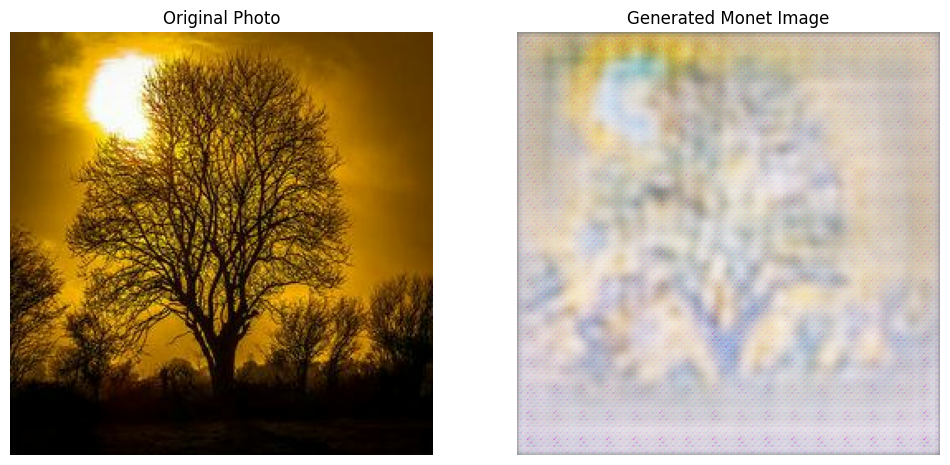

In [ ]:
# Initial training loop
EPOCHS = 100
for epoch in range(EPOCHS):
    for real_image, real_monet_image in zip(photo_dataset, monet_dataset):
        g_loss, d_x_loss, d_y_loss = train_step(real_image, real_monet_image)
    print(f"Epoch {epoch + 1}/{EPOCHS} | Gen Loss: {g_loss:.4f} | Disc Loss (X): {d_x_loss:.4f} | Disc Loss (Y): {d_y_loss:.4f}")

    # Save model checkpoints periodically
    if (epoch + 1) % 10 == 0:
        cyclegan.generator_g.save_weights(f'cyclegan_generator_g_epoch_{epoch + 1}.weights.h5')
        cyclegan.generator_f.save_weights(f'cyclegan_generator_f_epoch_{epoch + 1}.weights.h5')
        cyclegan.discriminator_x.save_weights(f'cyclegan_discriminator_x_epoch_{epoch + 1}.weights.h5')
        cyclegan.discriminator_y.save_weights(f'cyclegan_discriminator_y_epoch_{epoch + 1}.weights.h5')

    # Visualization at the end of each 25 epochs
    if (epoch + 1) % 25 == 0:
        test_image = real_image[0]
        generated_image = cyclegan.generator_g(test_image[None, ...], training=False)[0]
        test_image_rescaled = (test_image + 1) * 0.5
        generated_image_rescaled = (generated_image + 1) * 0.5
        test_image_clipped = np.clip(test_image_rescaled, 0, 1)
        generated_image_clipped = np.clip(generated_image_rescaled, 0, 1)
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(test_image_clipped)
        plt.title("Original Photo")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(generated_image_clipped)
        plt.title("Generated Monet Image")
        plt.axis('off')

        plt.show()

# Save the model at the end of training
cyclegan.generator_g.save_weights('cyclegan_generator_g_final.weights.h5')
cyclegan.generator_f.save_weights('cyclegan_generator_f_final.weights.h5')
cyclegan.discriminator_x.save_weights('cyclegan_discriminator_x_final.weights.h5')
cyclegan.discriminator_y.save_weights('cyclegan_discriminator_y_final.weights.h5')

In [ ]:
# Function to calculate FID
def calculate_fid(real_images, generated_images):
    # Load InceptionV3 model pre-trained on ImageNet
    model = InceptionV3(include_top=False, weights='imagenet', pooling='avg')

    # Preprocess images for InceptionV3
    real_images = tf.image.resize(real_images, (299, 299))
    generated_images = tf.image.resize(generated_images, (299, 299))

    # Get the feature vectors from InceptionV3
    real_features = model(real_images)
    generated_features = model(generated_images)

    # Calculate mean and covariance of the feature vectors
    mu_real = np.mean(real_features, axis=0)
    mu_generated = np.mean(generated_features, axis=0)

    cov_real = np.cov(real_features, rowvar=False)
    cov_generated = np.cov(generated_features, rowvar=False)

    # Compute the FID score
    diff = mu_real - mu_generated
    cov_sqrt = sqrtm(cov_real @ cov_generated)

    fid_score = np.sum(diff ** 2) + np.trace(cov_real + cov_generated - 2 * cov_sqrt)
    return fid_score

# Load a batch of real Monet images from your dataset
real_images = next(iter(monet_dataset))

# Generate Monet-style images from a batch of photos
photo_batch = next(iter(photo_dataset))
generated_images = cyclegan.generator_g(photo_batch, training=False)

# Calculate FID
fid = np.real(calculate_fid(real_images, generated_images))
print(f"FID Score: {fid}")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
FID Score: 408.92190574502706


# **STEP 4: RESULTS & ANALYSIS**

*Initial Training Phase*

In our initial CycleGAN training over 100 epochs, we observed trends in both generator and discriminator loss that reveal key aspects of the model’s learning process.
<br><br>
**Generator Loss**

Starting from an initial high of 3.2844, the generator loss gradually decreases, stabilizing between approximately 1.6 and 2.2 throughout most of the training. This reduction suggests that the generator is learning to produce images that increasingly “fool” the discriminator. However, periodic fluctuations indicate that the generator’s progress is not entirely stable, with brief periods of divergence before restabilizing.

**Discriminator Loss (X and Y)**

During the initial epochs, both discriminator losses show a sharp decline, reflecting the discriminators’ rapid learning to differentiate real from generated images. This might indicate overfitting, where the discriminators become overly confident in distinguishing generated images from real ones.

**Model Stability**

We noticed moments of instability, with spikes in loss values followed by periods of stabilization. This cyclical fluctuation is typical in adversarial training, where the generator periodically “catches up” to the discriminator’s learned patterns.

**FID Score**

Using the trained model, we generated Monet-style images and calculated the Fréchet Inception Distance (FID) score to quantify image quality. An initial FID of 408.92 suggests moderate success, though it indicates a notable gap between generated Monet-style images and the true distribution.

**Visual Analysis**

We monitored image quality by observing generated Monet-style images every 25 epochs. While there are gradual improvements, the images still exhibit an unnatural quality.
<br><br>
*Refinement with a Lower Learning Rate*

To improve results, we reduced the learning rate from 0.0002 to 0.00002 and ran another 100 epochs. In this phase, we observed stabilized losses, potentially indicating better convergence. However, the small discriminator losses hint at overfitting risks. The FID score improved to 379.25, showing a positive trend but still leaving room for optimization. This subtle improvement could result from the additional training epochs, the lower learning rate, or both.

As a final step we generate 7000 images with our newly trained model and submit them to the Kaggle competition I’m Something of a Painter Myself. The submitted images are measured using the Memorization-informed Fréchet Inception Distance (MiFid), which is a modification of the FID measurement that we used before. Our resulting score is 216.66968, which would confirm that our model has done moderately well, but that there is an opportunity to continue improving, ossibly through further iterations or hypertuning.

In [ ]:
# Optimizers and loss functions with lower learning rate
generator_g_optimizer_2 = tf.keras.optimizers.Adam(learning_rate=0.00002, beta_1=0.5)
generator_f_optimizer_2 = tf.keras.optimizers.Adam(learning_rate=0.00002, beta_1=0.5)
discriminator_x_optimizer_2 = tf.keras.optimizers.Adam(learning_rate=0.00002, beta_1=0.5)
discriminator_y_optimizer_2 = tf.keras.optimizers.Adam(learning_rate=0.00002, beta_1=0.5)

In [ ]:
@tf.function
def train_step_2(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape_g, tf.GradientTape(persistent=True) as tape_d:
        # Generate fake images
        fake_y = cyclegan.generator_g(real_x, training=True)
        fake_x = cyclegan.generator_f(real_y, training=True)

        # Cycle Consistency
        cycled_x = cyclegan.generator_f(fake_y, training=True)
        cycled_y = cyclegan.generator_g(fake_x, training=True)

        # Identity Mapping
        same_x = cyclegan.generator_f(real_x, training=True)
        same_y = cyclegan.generator_g(real_y, training=True)

        # Calculate generator losses
        g_loss = generator_loss(real_x, real_y, fake_x, fake_y, cycled_x, cycled_y, same_x, same_y)

        # Discriminator Loss
        real_d_x = cyclegan.discriminator_x(real_x, training=True)
        fake_d_x = cyclegan.discriminator_x(fake_x, training=True)
        d_x_loss = discriminator_loss(real_d_x, fake_d_x)

        real_d_y = cyclegan.discriminator_y(real_y, training=True)
        fake_d_y = cyclegan.discriminator_y(fake_y, training=True)
        d_y_loss = discriminator_loss(real_d_y, fake_d_y)

    # Calculate and apply gradients
    gradients_of_generator_g = tape_g.gradient(g_loss, cyclegan.generator_g.trainable_variables)
    gradients_of_generator_f = tape_g.gradient(g_loss, cyclegan.generator_f.trainable_variables)
    gradients_of_discriminator_x = tape_d.gradient(d_x_loss, cyclegan.discriminator_x.trainable_variables)
    gradients_of_discriminator_y = tape_d.gradient(d_y_loss, cyclegan.discriminator_y.trainable_variables)

    generator_g_optimizer_2.apply_gradients(zip(gradients_of_generator_g, cyclegan.generator_g.trainable_variables))
    generator_f_optimizer_2.apply_gradients(zip(gradients_of_generator_f, cyclegan.generator_f.trainable_variables))
    discriminator_x_optimizer_2.apply_gradients(zip(gradients_of_discriminator_x, cyclegan.discriminator_x.trainable_variables))
    discriminator_y_optimizer_2.apply_gradients(zip(gradients_of_discriminator_y, cyclegan.discriminator_y.trainable_variables))

    return g_loss, d_x_loss, d_y_loss

Epoch 1/100 | Gen Loss: 1.6184 | Disc Loss (X): 0.0003 | Disc Loss (Y): 0.0005
Epoch 2/100 | Gen Loss: 1.7227 | Disc Loss (X): 0.0001 | Disc Loss (Y): 0.0003
Epoch 3/100 | Gen Loss: 1.9082 | Disc Loss (X): 0.0001 | Disc Loss (Y): 0.0001
Epoch 4/100 | Gen Loss: 1.8992 | Disc Loss (X): 0.0002 | Disc Loss (Y): 0.0013
Epoch 5/100 | Gen Loss: 1.6822 | Disc Loss (X): 0.0002 | Disc Loss (Y): 0.0003
Epoch 6/100 | Gen Loss: 1.5194 | Disc Loss (X): 0.0001 | Disc Loss (Y): 0.0056
Epoch 7/100 | Gen Loss: 1.5094 | Disc Loss (X): 0.0001 | Disc Loss (Y): 0.0004
Epoch 8/100 | Gen Loss: 2.0203 | Disc Loss (X): 0.0001 | Disc Loss (Y): 0.0010
Epoch 9/100 | Gen Loss: 1.9539 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0005
Epoch 10/100 | Gen Loss: 1.5105 | Disc Loss (X): 0.0001 | Disc Loss (Y): 0.0007
Epoch 11/100 | Gen Loss: 1.5747 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0014
Epoch 12/100 | Gen Loss: 1.5090 | Disc Loss (X): 0.0001 | Disc Loss (Y): 0.0015
Epoch 13/100 | Gen Loss: 1.5638 | Disc Loss (X): 

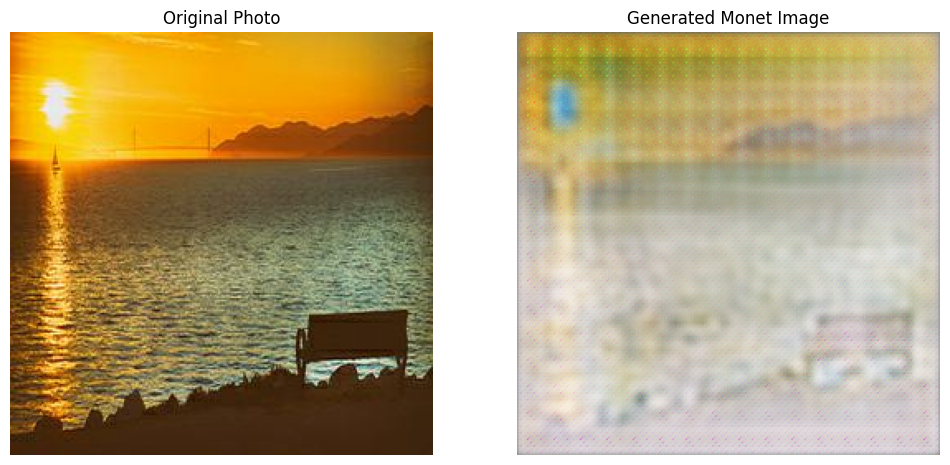

Epoch 26/100 | Gen Loss: 1.7170 | Disc Loss (X): 0.0001 | Disc Loss (Y): 0.0011
Epoch 27/100 | Gen Loss: 1.5191 | Disc Loss (X): 0.0001 | Disc Loss (Y): 0.0012
Epoch 28/100 | Gen Loss: 1.8528 | Disc Loss (X): 0.0001 | Disc Loss (Y): 0.0009
Epoch 29/100 | Gen Loss: 1.6490 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0007
Epoch 30/100 | Gen Loss: 1.9989 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0151
Epoch 31/100 | Gen Loss: 1.5908 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0067
Epoch 32/100 | Gen Loss: 1.7158 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0003
Epoch 33/100 | Gen Loss: 1.7094 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0037
Epoch 34/100 | Gen Loss: 1.7711 | Disc Loss (X): 0.0014 | Disc Loss (Y): 0.0706
Epoch 35/100 | Gen Loss: 1.5244 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0042
Epoch 36/100 | Gen Loss: 1.7418 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0097
Epoch 37/100 | Gen Loss: 1.6059 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0152
Epoch 38/100 | Gen Loss: 1.7083 | Disc L

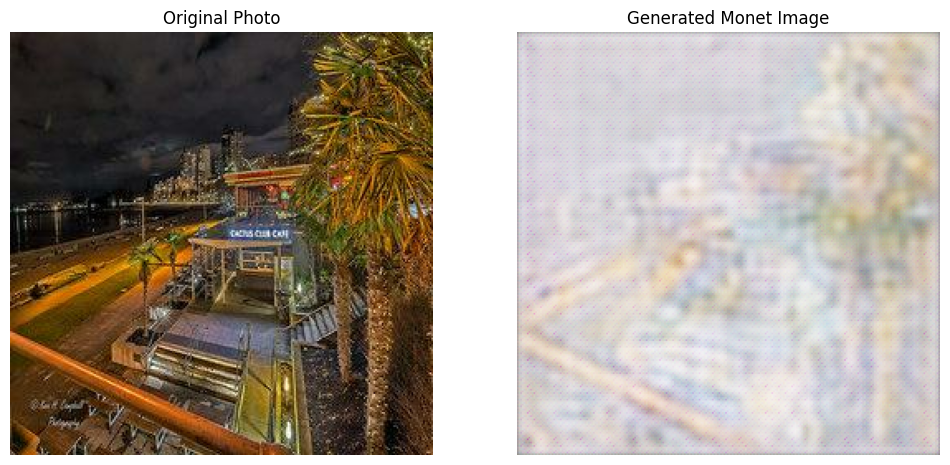

Epoch 51/100 | Gen Loss: 1.7261 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0112
Epoch 52/100 | Gen Loss: 1.5528 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0120
Epoch 53/100 | Gen Loss: 1.5333 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0030
Epoch 54/100 | Gen Loss: 1.5924 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0018
Epoch 55/100 | Gen Loss: 1.6655 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0019
Epoch 56/100 | Gen Loss: 1.8967 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0118
Epoch 57/100 | Gen Loss: 1.5774 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0010
Epoch 58/100 | Gen Loss: 1.6286 | Disc Loss (X): 0.0006 | Disc Loss (Y): 0.0018
Epoch 59/100 | Gen Loss: 1.6434 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0056
Epoch 60/100 | Gen Loss: 1.6051 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0067
Epoch 61/100 | Gen Loss: 1.7332 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0004
Epoch 62/100 | Gen Loss: 1.7972 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0034
Epoch 63/100 | Gen Loss: 1.6623 | Disc L

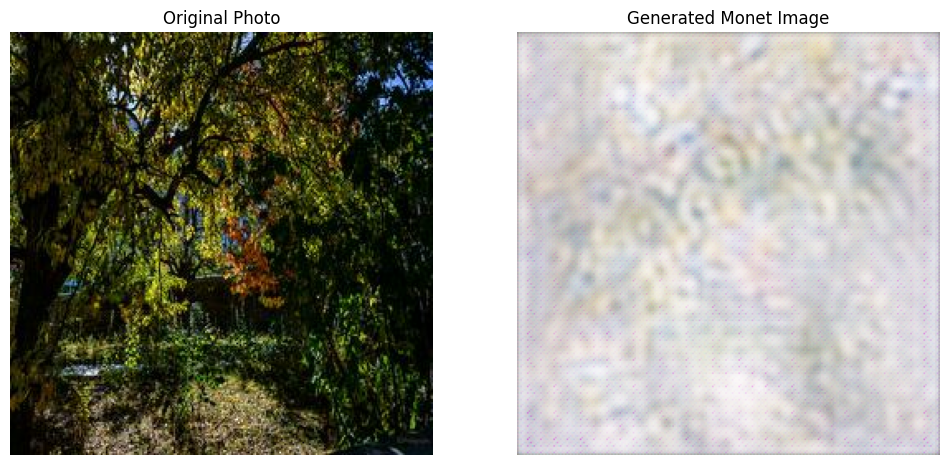

Epoch 76/100 | Gen Loss: 1.6120 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0007
Epoch 77/100 | Gen Loss: 1.6732 | Disc Loss (X): 0.0001 | Disc Loss (Y): 0.0024
Epoch 78/100 | Gen Loss: 1.6644 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0004
Epoch 79/100 | Gen Loss: 1.6348 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0065
Epoch 80/100 | Gen Loss: 1.5997 | Disc Loss (X): 0.0001 | Disc Loss (Y): 0.0005
Epoch 81/100 | Gen Loss: 1.7308 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0001
Epoch 82/100 | Gen Loss: 1.9229 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0008
Epoch 83/100 | Gen Loss: 1.5339 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0022
Epoch 84/100 | Gen Loss: 2.0020 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0003
Epoch 85/100 | Gen Loss: 1.8522 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0012
Epoch 86/100 | Gen Loss: 1.7752 | Disc Loss (X): 0.0000 | Disc Loss (Y): 0.0004
Epoch 87/100 | Gen Loss: 1.6190 | Disc Loss (X): 0.0001 | Disc Loss (Y): 0.0003
Epoch 88/100 | Gen Loss: 1.6899 | Disc L

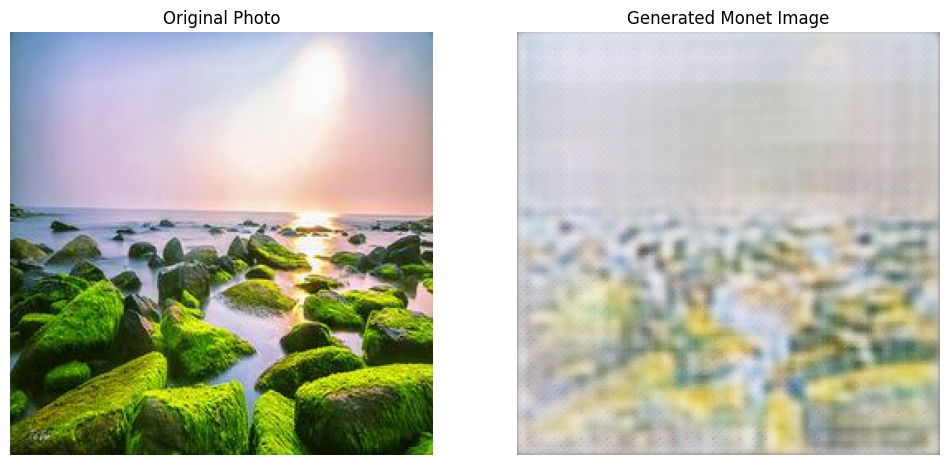

In [ ]:
# Training loop with lower learning rate
EPOCHS = 100
for epoch in range(EPOCHS):
    for real_image, real_monet_image in zip(photo_dataset, monet_dataset):
        g_loss, d_x_loss, d_y_loss = train_step_2(real_image, real_monet_image)
    print(f"Epoch {epoch + 1}/{EPOCHS} | Gen Loss: {g_loss:.4f} | Disc Loss (X): {d_x_loss:.4f} | Disc Loss (Y): {d_y_loss:.4f}")

    # Save model checkpoints periodically
    if (epoch + 1) % 10 == 0:
        cyclegan.generator_g.save_weights(f'cyclegan_generator_g_epoch_{epoch + 1}.weights.h5')
        cyclegan.generator_f.save_weights(f'cyclegan_generator_f_epoch_{epoch + 1}.weights.h5')
        cyclegan.discriminator_x.save_weights(f'cyclegan_discriminator_x_epoch_{epoch + 1}.weights.h5')
        cyclegan.discriminator_y.save_weights(f'cyclegan_discriminator_y_epoch_{epoch + 1}.weights.h5')

    # Visualization at the end of each 25 epochs
    if (epoch + 1) % 25 == 0:
        test_image = real_image[0]  # Take one image for testing
        generated_image = cyclegan.generator_g(test_image[None, ...], training=False)[0]
        test_image_rescaled = (test_image + 1) * 0.5
        generated_image_rescaled = (generated_image + 1) * 0.5
        test_image_clipped = np.clip(test_image_rescaled, 0, 1)
        generated_image_clipped = np.clip(generated_image_rescaled, 0, 1)
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(test_image_clipped)
        plt.title("Original Photo")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(generated_image_clipped)
        plt.title("Generated Monet Image")
        plt.axis('off')

        plt.show()

# Save the model at the end of training
cyclegan.generator_g.save_weights('cyclegan_generator_g_final.weights.h5')
cyclegan.generator_f.save_weights('cyclegan_generator_f_final.weights.h5')
cyclegan.discriminator_x.save_weights('cyclegan_discriminator_x_final.weights.h5')
cyclegan.discriminator_y.save_weights('cyclegan_discriminator_y_final.weights.h5')

In [ ]:
# Load a batch of real Monet images from your dataset
real_images = next(iter(monet_dataset))

# Generate Monet-style images from a batch of photos
photo_batch = next(iter(photo_dataset))
generated_images = cyclegan.generator_g(photo_batch, training=False)

# Calculate new FID
fid = np.real(calculate_fid(real_images, generated_images))
print(f"FID Score: {fid}")

FID Score: 379.2503351064202


In [ ]:
# Define paths and number of images to generate
num_images = 7000
photo_images = os.listdir(photo_path)
zip_filename = '/kaggle/working/images.zip'

# Open the zip file for writing
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:

    # Loop to generate images
    for i in range(num_images):

        # Select a random photo image and load it
        photo_img_path = os.path.join(photo_path, random.choice(photo_images))
        img = Image.open(photo_img_path).resize((256, 256))
        img_array = np.array(img) / 127.5 - 1.0

        # Generate Monet-style image
        generated_img = cyclegan.generator_g.predict(np.expand_dims(img_array, axis=0), verbose=0)[0]

        # Convert to [0, 255] range for JPEG format
        generated_img = ((generated_img + 1.0) * 127.5).astype(np.uint8)

        # Save the image to the zip file
        img_name = f'generated_{i+1:04d}.jpg'
        with zipf.open(img_name, 'w') as img_file:
            Image.fromarray(generated_img).save(img_file, format='JPEG')

print(f'Generated {num_images} images and saved directly to {zip_filename}')

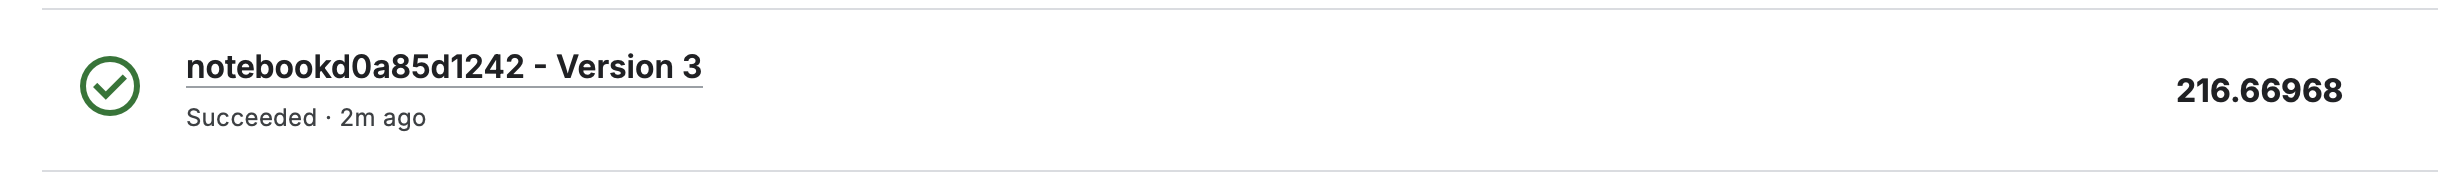

# **STEP 5: CONCLUSION**
The focus of this project was to explore the performance of a CycleGAN model trained to transform photo images into Monet-style paintings. Our initial training phase showed encouraging progress, with a gradual decline in generator loss and rapid adaptation by the model’s discriminators. However, the training exhibited some instability, a common challenge in GAN models, as the generator and discriminators continuously adjust to each other’s improvements.

The Fréchet Inception Distance (FID) score, an indicator of visual similarity between model-generated and real Monet images, improved over successive training epochs. This was aided by our strategy of reducing the learning rate by a factor of 10 (from 0.002 to 0.00002), which promoted further stabilization in losses and moderate visual enhancements. Although the generated images became more aligned with the Monet style, they still contained noticeable artifacts. This is confirmed by our Kaggle submission score of 216.66968.

While our current results show progress, additional iterations with further hyperparameter tuning and training enhancements are likely needed to achieve high-quality Monet-style transformations. Future improvements could include experimenting with alternative GAN architectures, adjusting training strategies, or implementing advanced regularization techniques. Overall, this CycleGAN implementation demonstrates a promising start, providing valuable insights into the potential of GAN models in deep learning applications.




---

